In [70]:
import gym
import pheno_game
from omegaconf import OmegaConf
import numpy as np

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio


# currently installed theme will be used to
# set plot style if noarguments provided
#jtplot.style()
from pheno_game.envs.pheno_env import minmax
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [71]:
mpl.rc('image', cmap='gist_earth')
plt.rcParams.update({'font.size': 25})
plt.rcParams['axes.grid'] = False


In [72]:
def minmax(x, domain, codomain, reverse=False):
    min_dom, max_dom = domain
    min_codom, max_codom = codomain
    A,B = max_codom - min_codom, min_codom
    if reverse:
        return np.clip((x - B)*(max_dom-min_dom)/A + min_dom, min_dom, max_dom)
    else:
        return np.clip(A*(x - min_dom)/(max_dom-min_dom)+B, min_codom, max_codom)



## Defining the observable

In [4]:
def eggbox(x1,x2):
    '''
    Args:
    ----
    x1
    x2
    
    Returns:
    -------
    observable
    '''
    model = lambda x1, x2: (2 + np.cos(x1/2)*np.cos(x2/2))**5
    obs = model(x1,x2)
    return obs

In [87]:
def gaussian_2d(x,y,mu1=13.5,mu2=13.5,height=100):
    '''
    Args: x1, x2
    Returns: observable
    '''
    A = height # Gaussian height
    x_0, y_0 = mu1, mu2 # Gaussian centers
    sigma_x, sigma_y = 0.5, 0.5

    gaussian = A * np.exp(-(((x - x_0)**2 / (2 * sigma_x**2)) + ((y - y_0)**2 / (2 * sigma_y**2))))
    return gaussian

def double_gaussian(x,y): 
    '''
    Args: x1, x2
    Returns: observable
    '''
    gaussian = gaussian_2d(x,y)\
            + gaussian_2d(x,y,mu1=11.5,mu2=11.5,height=100)
    return gaussian



In [84]:
def distance_likelihood(variable, goal, maximum=1,acceptance=20):
    stability = acceptance**2*np.exp(-maximum)
    dlh = -np.log(((variable-goal)**2+stability)*(acceptance)**(-2))
    return dlh
def softplus_likelihood(variable, goal, maximum=1,acceptance=20):
    softplus = np.log(1+ np.exp(distance_likelihood(variable,goal)))
    return 
def gaussian_likelihood(variable,goal,sigma=10):
    lh = np.exp(- (variable-goal)**2/(2*sigma**2))
    return lh
def likelihood(variable,goal):
    return gaussian_likelihood(variable, goal)

def full_simulation(x1, x2, goal, simulation):
    obs = simulation(x1,x2)
    lh = likelihood(obs, goal)
    return lh

In [85]:
def simulation_space(bottom, top, samples):
    x = np.linspace(bottom, top , samples)
    y = np.linspace(bottom, top , samples)
    X,Y = np.meshgrid(x,y)

    X_norm = minmax(X, [bottom, top ], [-1,1])
    Y_norm = minmax(Y, [bottom, top ], [-1,1])
    return X.flatten(), Y.flatten(), X_norm.flatten(), Y_norm.flatten()
    


In [77]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=10, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
jtplot.reset()

In [78]:
plt.style.use('default')

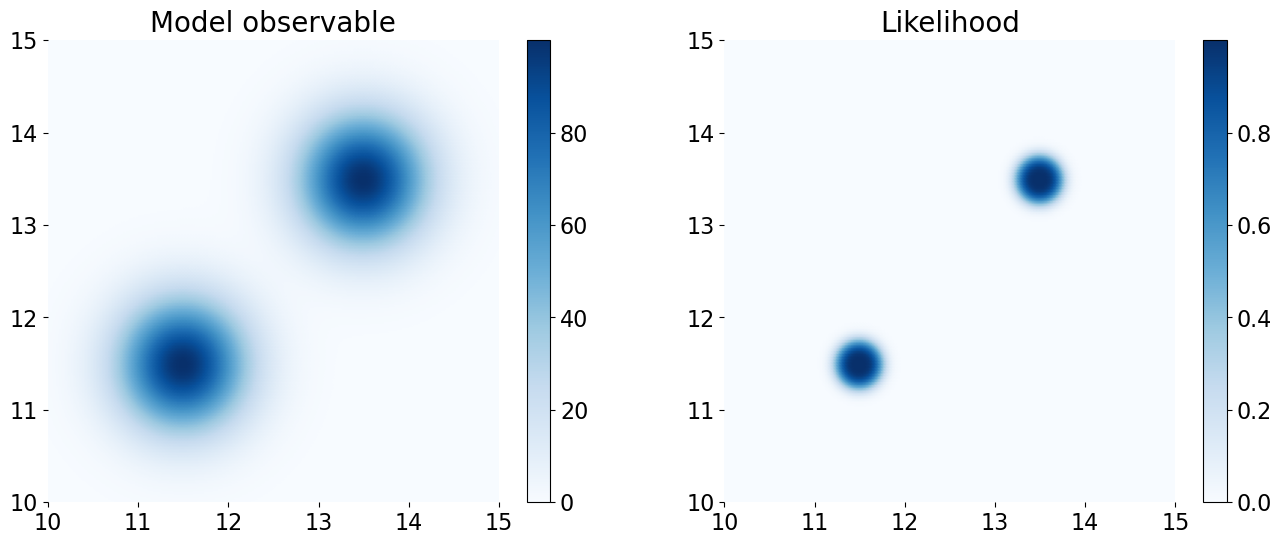

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl

name = 'gaussian-10-15pi'
bottom, top =10, 15
samples = 300
goal=100

x, y, X_norm, Y_norm = simulation_space(bottom, top, samples)
lh = full_simulation(x,y,goal=goal,simulation=double_gaussian)
obs = double_gaussian(x,y)

plt.style.use('seaborn-pastel')
mpl.rc('image', cmap='Blues')

fig, ax = plt.subplots(1,2, figsize=(16,6))


cb = ax[0].scatter(x,y,c=obs, s=2)
cbar = fig.colorbar(cb, ax=ax[0])
cbar.ax.tick_params(labelsize=16) 
ax[0].set_title('Model observable', fontsize=20)
ax[0].set_xlim(bottom, top)
ax[0].set_ylim(bottom, top)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

cb = ax[1].scatter(x,y,c=lh,s=2)
cbar = fig.colorbar(cb, ax=ax[1])
cbar.ax.tick_params(labelsize=16) 
ax[1].set_title('Likelihood', fontsize=20)
ax[1].set_xlim(bottom, top)
ax[1].set_ylim(bottom, top)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
# Set tick font size
for i in range(2):
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(16)

plt.savefig(name+'.png')
plt.show()


# Density in history

### Initial sampler

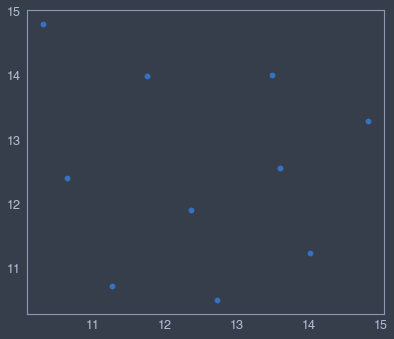

In [8]:
from skopt.space import Space
from skopt.sampler import Lhs

def initial_sampler(n_samples: int, bottom: float, top: float):
    n_samples = n_samples
    space = Space([np.array([bottom, top]), np.array([bottom, top])])
    lhs = Lhs(criterion="ratio", iterations=5000)
    x = lhs.generate(space.dimensions, n_samples)
    x = np.array(x)
    X = x[:,0]
    Y = x[:,1]
    return X, Y

x,y = initial_sampler(n_samples= 10,bottom = 10.,top = 15.)
plt.scatter(x,y)

In [9]:
from sklearn.neighbors import KernelDensity
def fit_kernel(x,y, kernel_type = 'gaussian', h=1):
    data = np.concatenate(
        (x.reshape(len(x),1), y.reshape(len(y),1)),
        axis=1
        )
    kernel = KernelDensity(bandwidth=h, kernel=kernel_type)
    kernel.fit(data)
    return kernel
def predict_density(x,y,kernel):
    data = np.concatenate(
        (x.reshape(len(x),1),y.reshape(len(y),1)),
        axis=1
        )
    logprob = kernel.score_samples(data)
    return np.exp(logprob)

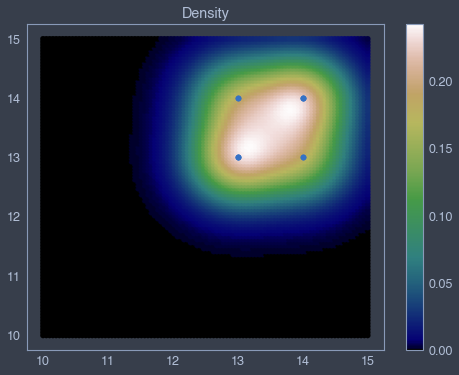

In [11]:
bottom, top = 10., 15.
samples = 100
goal=100
initial_samples = 10
x, y, X_norm, Y_norm = simulation_space(bottom, top, samples)
ix,iy = initial_sampler(initial_samples,13,14 )
kernel = fit_kernel(ix, iy,  kernel_type = 'gaussian', h=0.5)
densities = predict_density(x,y, kernel)


fig, ax = plt.subplots(1,1, figsize=(8,6))
cb = ax.scatter(x,y,c=densities)
ax.title.set_text('Density')
ax.scatter(ix,iy)
fig.colorbar(cb, ax=ax)




#### Sampling from the density model? 

(10.0, 15.0)

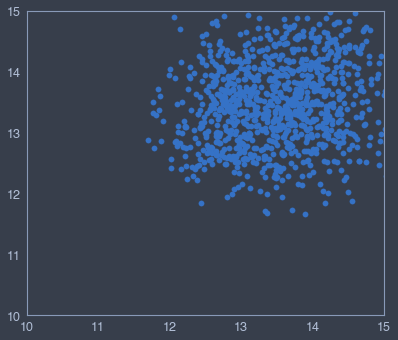

In [33]:
samples = kernel.sample(n_samples=1000).T
x,y = samples
ax = plt.scatter(x,y)
ax = plt.gca()
ax.set_xlim([bottom, top])
ax.set_ylim([bottom, top])

#### Saving and loading the density model? 

In [36]:
params = kernel.get_params??
params

{'algorithm': 'auto',
 'atol': 0,
 'bandwidth': 0.5,
 'breadth_first': True,
 'kernel': 'gaussian',
 'leaf_size': 40,
 'metric': 'euclidean',
 'metric_params': None,
 'rtol': 0}

## Kernel Density Estimation in scikit-learn
From: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb#scrollTo=PI1ApKvkPgap

In [20]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x 

x = make_data(1000)

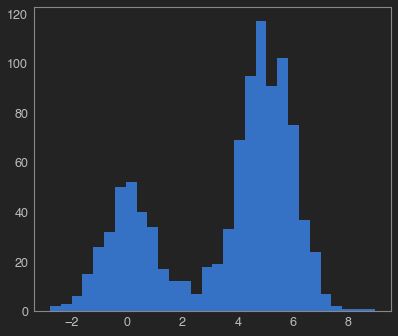

In [21]:
hist = plt.hist(x, bins=30)

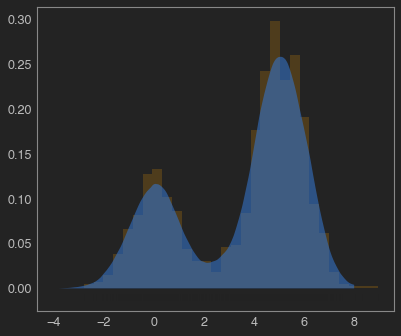

In [22]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='epanechnikov')
kde.fit(x[:, None])

x_d = np.linspace(-4, 8, 1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
hist = plt.hist(x, bins=30, density=True, alpha=0.2, color='Orange')
plt.fill_between(x_d, np.exp(logprob), alpha=0.6)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)



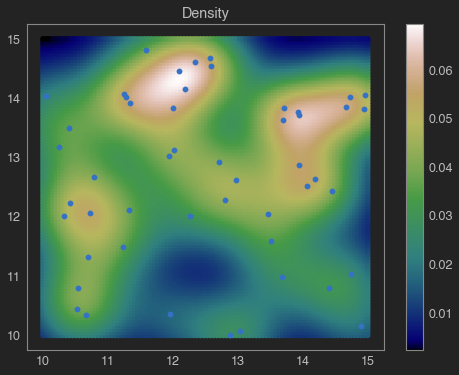

In [24]:
from IPython.display import clear_output
from tqdm import tqdm

n_steps = 50
bottom, top = 10., 15.
samples = 100
goal=100

samples_history = np.zeros((n_steps,2))
imgs = []
for step in range(n_steps):
    clear_output(wait=True)
    initial_samples = 10
    x, y, X_norm, Y_norm = simulation_space(bottom, top, samples)
    
    # Action 
    action = np.random.uniform(bottom,top,2)
    samples_history[step] = action
    
    # fit kernel and get densities for the space 
    data = samples_history[:step+1]
    kernel = fit_kernel(data[:,0], data[:,1],  kernel_type = 'gaussian', h=0.5)
    densities = predict_density(x,y, kernel)


    fig, ax = plt.subplots(1,1, figsize=(8,6))
    cb = ax.scatter(x,y,c=densities)
    ax.title.set_text('Density')
    ax.scatter(data[:,0],data[:,1])
    fig.colorbar(cb, ax=ax)
    imgs.append(fig2img(fig))
    plt.show()


### Reward and density

$$
\mathcal{R}(\lambda,\rho(\lambda)) = \eta_1 d \exp{\left(-\eta_2 \rho\right)}
$$

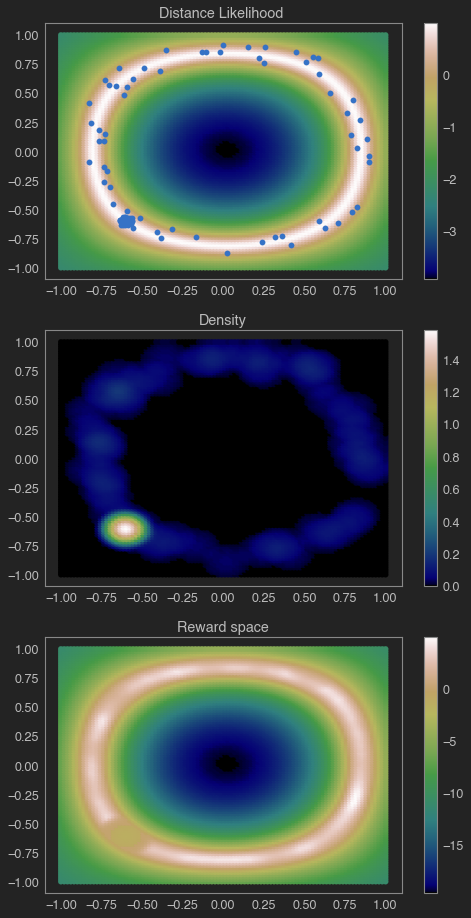

In [24]:
import time
n_steps = 100

bottom, top = 10., 15.
samples = 100
goal=100
images = []
samples_history = np.zeros((n_steps,2))
for step in range(n_steps):
    clear_output(wait=True)
    initial_samples = 10
    x, y, X_norm, Y_norm = simulation_space(bottom, top, samples)
    lh = full_simulation(x,y,goal=goal,simulation=eggbox)
    obs = eggbox(x,y)
    # Action 
    action = np.random.uniform(bottom,top,2)
    epsilon = 0.7
    if np.random.uniform(0,1) < epsilon:
        while full_simulation(*action,goal=goal,simulation=eggbox) < 0:
            action = np.random.uniform(bottom,top,2)
    else:
        action = np.random.uniform(10.9,11.1,2)

    
    samples_history[step] = action
    
    # fit kernel and get densities for the space 
    data = samples_history[:step+1]
    norm_data = minmax(data, [bottom, top ], [-1,1])
    kernel = fit_kernel(data[:,0], data[:,1],  kernel_type = 'epanechnikov', h=0.4)
    densities = predict_density(x,y, kernel)

        
 

    fig, ax = plt.subplots(3,1, figsize=(8,16))

    cb = ax[0].scatter(X_norm,Y_norm,c=lh)
    fig.colorbar(cb, ax=ax[0])
    ax[0].scatter(norm_data[:,0],norm_data[:,1])
    ax[0].title.set_text('Distance Likelihood ')
    
    cb = ax[1].scatter(X_norm,Y_norm,c=densities)
    ax[1].title.set_text('Density')
    #ax[1].scatter(norm_data[:,0],norm_data[:,1])
    fig.colorbar(cb, ax=ax[1])
    
    reward = 5*lh*np.exp(-5 * densities)*(1+np.sign(lh))/2 +\
        5*lh*(1-np.sign(lh))/2- densities*(1+np.sign(np.log(densities)))/2
                         
    cb = ax[2].scatter(X_norm,Y_norm,c=reward)
    ax[2].title.set_text('Reward space')
    #ax[2].scatter(norm_data[:,0],norm_data[:,1], cmap = 'turbo')
    fig.colorbar(cb, ax=ax[2])
    time.sleep(0.001)
    img = fig2img(fig)
    images.append(img)
    plt.show()

save_gif(images, 'Ideal_Agent')

# Gaussians model

In [543]:
grid_x, grid_y = np.mgrid[10:15:100j, 10:15:100j]
def gaussian_spot_2d(x,y,mu1=13.5,mu2=13.5,height=100):
    A = height # Gaussian height
    x_0, y_0 = mu1, mu2 # Gaussian centers
    sigma_x, sigma_y = 0.5, 0.5

    gaussian = A * np.exp(-(((x - x_0)**2 / (2 * sigma_x**2)) + ((y - y_0)**2 / (2 * sigma_y**2))))
    return gaussian

def double_gaussian_spot(x,y): 
    gaussian = gaussian_spot_2d(x,y)\
    + gaussian_spot_2d(x,y,mu1=11.5,mu2=11.5,height=100)
    return gaussian

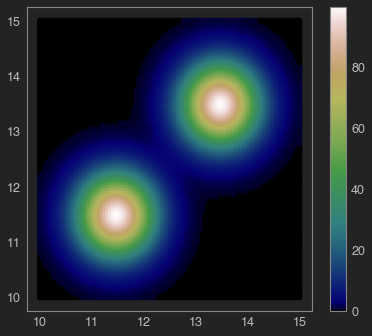

In [544]:
gaussian = double_gaussian_spot(grid_x, grid_y)
plt.scatter(grid_x, grid_y, c=gaussian)
plt.colorbar()

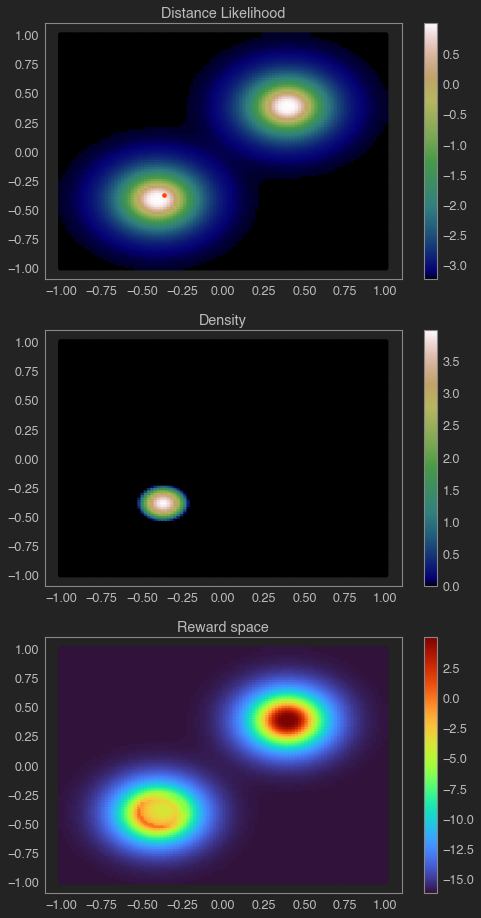

In [612]:
n_steps = 1

bottom, top = 10., 15.
samples = 100
goal=100

samples_history = np.zeros((n_steps,2))
images
for step in range(n_steps):
    clear_output(wait=True)
    initial_samples = 10
    x, y, X_norm, Y_norm = simulation_space(bottom, top, samples)
    lh = full_simulation(x,y,goal=goal,simulation=double_gaussian_spot)
    obs = eggbox(x,y)
    # Action 
    epsilon = 1
    if np.random.uniform(0,1) < epsilon:
        action = np.random.uniform(11.4,11.6,2)
    else:
        action = np.random.uniform(11,12,2)

    samples_history[step] = action
    
    # fit kernel and get densities for the space 
    data = samples_history[:step+1]
    norm_data = minmax(data, [bottom, top ], [-1,1])
    kernel = fit_kernel(data[:,0], data[:,1],  kernel_type = 'epanechnikov', h=0.4)
    densities = predict_density(x,y, kernel)

        
 

    fig, ax = plt.subplots(3,1, figsize=(8,16))

    cb = ax[0].scatter(X_norm,Y_norm,c=lh)
    fig.colorbar(cb, ax=ax[0])
    ax[0].scatter(norm_data[:,0],norm_data[:,1], color='orangered', s=20)
    ax[0].title.set_text('Distance Likelihood')
    
    cb = ax[1].scatter(X_norm,Y_norm,c=densities)
    ax[1].title.set_text('Density')
    #ax[1].scatter(norm_data[:,0],norm_data[:,1])
    fig.colorbar(cb, ax=ax[1])
    
    reward = 5*lh*np.exp(-5 * densities)*(1+np.sign(lh))/2 +\
        5*lh*(1-np.sign(lh))/2 - densities*(1+np.sign(np.log(densities)))/2
    cb = ax[2].scatter(X_norm,Y_norm,c=reward, cmap='turbo')
    ax[2].title.set_text('Reward space')
    #ax[2].scatter(norm_data[:,0],norm_data[:,1])
    fig.colorbar(cb, ax=ax[2])
    
    plt.show()

In [26]:

import imageio;
from IPython.display import Video;
imageio.mimwrite('gameplay.mp4', imgs, fps=30)
Video('gameplay.mp4')


In [19]:
from PIL import Image, ImageDraw
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
def save_gif(images: list, name: str, duration=40):
    images[0].save(name+'.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)